In [2]:
import numpy as np
from sympy import symbols
from contextlib import redirect_stdout
import subprocess
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from pathlib import Path

In [47]:
K = 16
d = 8
a = np.zeros(d + 1)
# a[2] = 1
a[2], a[4], a[8] = 1/2, -1, 1/8

In [48]:
def genF(energy, shift, E):
    Fmats = [np.zeros((K, K)) for _ in range(d)] + [np.eye(K)]
    for i in range(K):
        for j in range(K):
            term = vars[i + j + shift].subs([(E, energy)])
            for k in range(d):
                Fmats[k][i, j] = term.coeff(vars[k])
                if k == 0:
                    Fmats[k][i, j] *= -1
    return Fmats

def create_input(energy, E, shift, file):
    with redirect_stdout(file):
        print(f'*Energy: {energy}')
        print(d) # mDIM
        print(1) # nBLOCK
        print(K) # bLOCKsTRUCT
        c = np.zeros(d)
        c[-1] = 1
        print(*c)
        Fmats = genF(energy, shift, E)
        for Fmat in Fmats:
            print(*Fmat.reshape(-1))

def solve(shift, E):
    Es = np.linspace(0, 10, num = 500)
    ts = np.zeros_like(Es)
    # ini_file = Path('aho.ini')
    # if ini_file.exists():
    #     ini_file.unlink()
    for i in range(Es.shape[0]):
        with open('aho.dat','w') as f:
            create_input(Es[i], E, shift, f)
        args = ['sdpa_gmp','aho.dat','aho.result']
        # if ini_file.exists():
        #     args.append(ini_file.name)
        subprocess.run(args, stdout=subprocess.DEVNULL)
        with open('aho.result','r') as f:
            lines = f.readlines()
            for line in lines:
                if line.startswith('objValPrimal'):
                    t = float(line.split(' ')[2])
                    ts[i] = np.log(np.abs(t))
                    break
            # if i == 0:
            #     p1 = lines.index('xVec = \n') + 1
            #     p2 = lines.index('xMat = \n') + 2
            #     p3 = lines.index('yMat = \n') + 2
            #     p4 = len(lines) - 4
            #     xVec = lines[p1][:-1]
            #     xMat = ''.join([lines[i][:-1] for i in range(p2, p3 - 3)])
            #     yMat = ''.join([lines[i][:-1] for i in range(p3, p4)])
            #     with open('aho.ini', 'w') as inif:
            #         with redirect_stdout(inif):
            #             print(xVec)
            #             print(xMat)
            #             print(yMat)
    np.savez(f'./data/aho_K_{K}_shift_{shift}',Es=Es,ts=ts)

In [49]:
vars = [symbols(f'x_{i}') for i in range(d)]
# note that x_0 = 1
E = symbols('E')
m = 0
lim = 5 * K
while d + m <= lim:
    t = 4 * (m+1) * E * vars[m]
    if m >= 2:
        t = t + m * (m * m - 1) * vars[m - 2]
    for n in range(1, d):
        t = t - 2 * (n + 2 * m + 2) * a[n] * vars[n + m]
    t = t / (2 * a[d] * (d + 2 * m + 2))
    vars.append(t.simplify())
    m += 1

In [50]:
def create_shift_plot(shifts):
    fig, ax = plt.subplots()
    # ax.set_title('log(|t|) vs E with varying shifts')
    ax.set_title('Anharmonic oscillator energy spectrum')
    ax.set_xlabel('E')
    ax.set_ylabel('log(|t|)')
    for shift in shifts:
        data = np.load(f'./data/aho_K_{K}_shift_{shift}.npz')
        dips = data['Es'][find_peaks(-data['ts'],prominence=1)[0]]
        print(dips)
        for dip in dips:
            plt.axvline(x=dip,ls='--',c='grey',alpha=0.7,zorder=-2)
        # ax.plot(data['Es'], data['ts'], label=f'(K, S) = {(K, shift)}')
        ax.plot(data['Es'], data['ts'], label=f'K = {K}')
    ax.legend()
    ax.grid()
    return fig, ax

In [51]:
shifts = [0]
for shift in shifts:
    solve(shift, E)

[0.46092184 1.98396794 4.86973948 8.93787575 9.33867735]


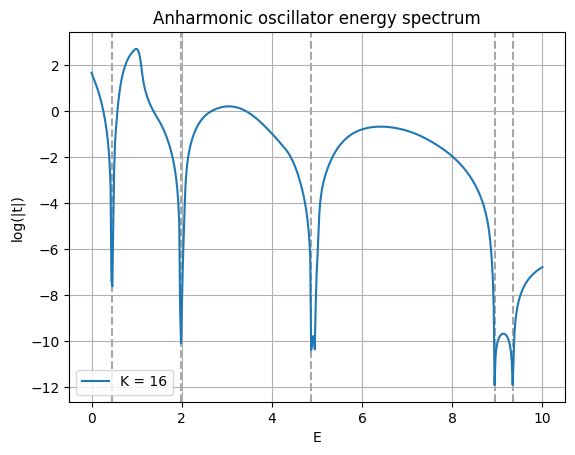

In [52]:
shifts = [0]
fig, ax = create_shift_plot(shifts)
plt.show()

[0.44088176 1.96392786 4.88977956 9.01803607]


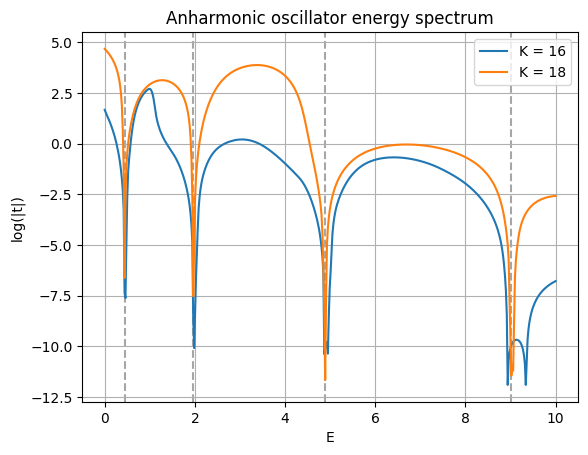

In [3]:
Ks = [16, 18]
fig, ax = plt.subplots()
ax.set_title('Anharmonic oscillator energy spectrum')
ax.set_xlabel('E')
ax.set_ylabel('log(|t|)')
for K in Ks:
    data = np.load(f'./data/aho_K_{K}_shift_{0}.npz')
    if K == max(Ks):
        dips = data['Es'][find_peaks(-data['ts'],prominence=1)[0]]
        print(dips)
        for dip in dips:
            plt.axvline(x=dip,ls='--',c='grey',alpha=0.7,zorder=-2)
    ax.plot(data['Es'], data['ts'], label=f'K = {K}')
ax.legend()
ax.grid()
plt.show()

In [53]:
# plt.plot(Es, ts, label=f'K = {K}')
# dips = Es[find_peaks(-ts,prominence=0.1)[0]]
# print(dips)
# for dip in dips:
#     plt.axvline(x=dip,ls='--',c='grey',alpha=0.7,zorder=-2)
# plt.title('log(|t|) vs E')
# plt.xlabel('E')
# plt.ylabel('log(|t|)')
# plt.legend()
# plt.grid()
# plt.show()